In [1]:
from dataset import ClsDataset
from torch.utils.data import DataLoader
import matplotlib as mpl
import matplotlib.pyplot as plt

data_dir = './validation_11'
data_set = ClsDataset(data_dir)
data_loader = DataLoader(
    data_set,
    batch_size=15,
    shuffle=True,
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /opt/ml/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

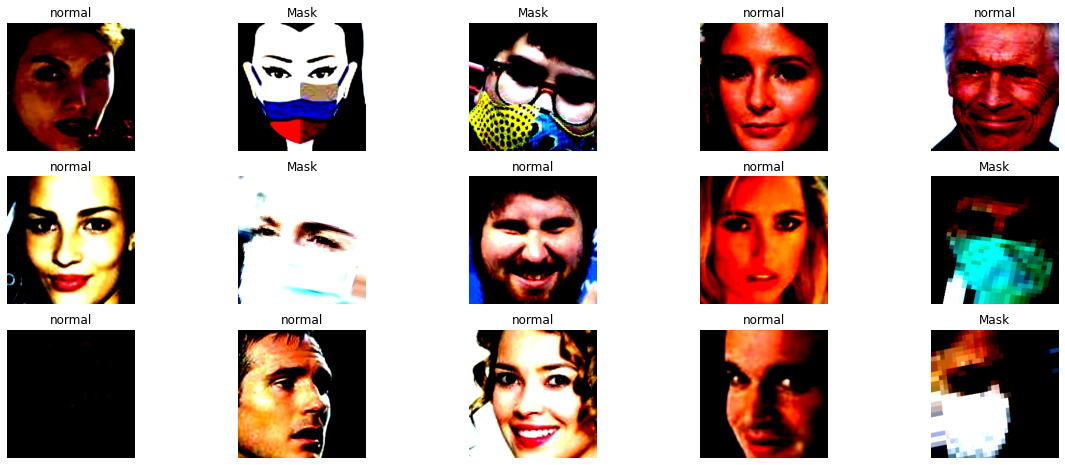

In [2]:
from model import ClsModel
import os
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
m = torch.nn.Sigmoid()

model = ClsModel(num_classes=1)

model_path = './model/exp3/best.pth'
model.load_state_dict(torch.load(model_path, map_location=device))  #모델 불러오기

model = model.to(device)
model.eval()

d = next(iter(data_loader))                      #loader에서 배치사이즈 만큼 random하게 뽑아온다.
fig, ax = plt.subplots(3, 5, figsize=(20,8))
ax = ax.flatten()

with torch.no_grad():

    for i in range(15):
        data = d[0][i]
        label = d[1][i]
        
        ax[i].imshow(data.permute(1,2,0))   #plt에 맞춰서 permute
        
        data = data.to(device)

        out = model(data.unsqueeze(0))      #기존 3차원에서 배치까지 포함된 4차원에 맞추기 위해 unsqueeze
        out = m(out)

        if round(out.item()) == 0:     
            title = 'Mask'
        else:
            title = 'normal'
            
        ax[i].set_title(title)
        ax[i].axis('off')

plt.show()

In [6]:
data.shape

torch.Size([3, 224, 224])

In [31]:
### Grad-CAM
save_feat=[]
def hook_feat(module, input, output):   # feature 뽑기
  save_feat.append(output)
  return output


save_grad=[]
def hook_grad(grad):    # Gradient 뽑기
  save_grad.append(grad)
  return grad


def vis_gradcam(model, img):
  model.eval()

  model.model._blocks[-1]._swish.register_forward_hook(hook_feat)
  
  img = img.unsqueeze(0)
  s = model(img)[0]

  save_feat[0].register_hook(hook_grad)
  
  y = torch.argmax(s).item()
  s_y = s[y]
  s_y.backward()


  gap_layer  = torch.nn.AdaptiveAvgPool2d(1)
  alpha = gap_layer(save_grad[0][0].squeeze())
  A = save_feat[0].squeeze()

  relu_layer = torch.nn.ReLU()

  weighted_sum = torch.sum(alpha*A, dim=0)
  grad_CAM = relu_layer(weighted_sum)

  grad_CAM = grad_CAM.unsqueeze(0)
  grad_CAM = grad_CAM.unsqueeze(0)

  upscale_layer = torch.nn.Upsample(scale_factor=img.shape[-1]/grad_CAM.shape[-1], mode='bilinear')

  grad_CAM = upscale_layer(grad_CAM)
  grad_CAM = grad_CAM/torch.max(grad_CAM)

  # Plotting  
  img = img.squeeze()
  img = img.cpu()
  img = img.permute(1,2,0)
  grad_CAM = grad_CAM.cpu()
  grad_CAM = grad_CAM.squeeze().detach().numpy()

  plt.figure(figsize=(8, 8))
  plt.imshow(img)
  plt.imshow(grad_CAM, cmap='jet', alpha = 0.5)
  plt.show

  return grad_CAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[1.        , 1.        , 1.        , ..., 0.9874441 , 0.9874441 ,
        0.9874441 ],
       [1.        , 1.        , 1.        , ..., 0.9874441 , 0.9874441 ,
        0.9874441 ],
       [1.        , 1.        , 1.        , ..., 0.9874441 , 0.9874441 ,
        0.9874441 ],
       ...,
       [0.7084894 , 0.7084894 , 0.7084894 , ..., 0.99502623, 0.99502623,
        0.99502623],
       [0.7084894 , 0.7084894 , 0.7084894 , ..., 0.99502623, 0.99502623,
        0.99502623],
       [0.7084894 , 0.7084894 , 0.7084894 , ..., 0.99502623, 0.99502623,
        0.99502623]], dtype=float32)

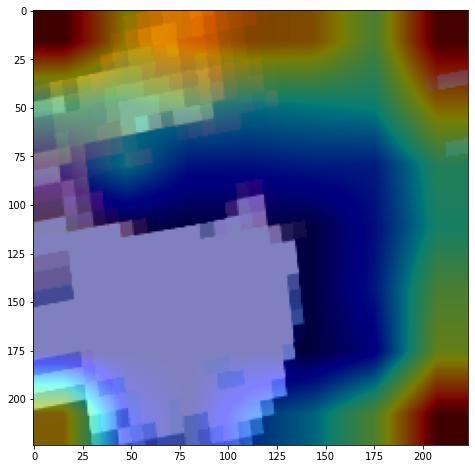

In [33]:
vis_gradcam(model, data)

In [30]:
model.model._blocks[-1]

MBConvBlock(
  (_expand_conv): Conv2dStaticSamePadding(
    192, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False
    (static_padding): Identity()
  )
  (_bn0): BatchNorm2d(1152, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_depthwise_conv): Conv2dStaticSamePadding(
    1152, 1152, kernel_size=(3, 3), stride=[1, 1], groups=1152, bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn1): BatchNorm2d(1152, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_se_reduce): Conv2dStaticSamePadding(
    1152, 48, kernel_size=(1, 1), stride=(1, 1)
    (static_padding): Identity()
  )
  (_se_expand): Conv2dStaticSamePadding(
    48, 1152, kernel_size=(1, 1), stride=(1, 1)
    (static_padding): Identity()
  )
  (_project_conv): Conv2dStaticSamePadding(
    1152, 320, kernel_size=(1, 1), stride=(1, 1), bias=False
    (static_padding): Identity()
  )
  (_bn2): BatchNorm2d(320, eps=0.001, moment